---
title: Pytorch入门实战：神经机器翻译   
date: 2018-12-11 01:46:14  
updated: 2018-12-11 01:46:14  
tags:   
mathjax: true  
categories: ['深度学习', 'Pytorch与Mxnet']  

---

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 载入数据文件

这个项目的数据是很多的的英语法语翻译对。数据太大没有包含在 repo 中，所以下载到``data / eng-fra.txt``。 该文件是以制表符分隔的翻译对列表：

`I am cold.    J'ai froid.`

[下载地址](https://download.pytorch.org/tutorial/data.zip)



我们将语言中的每个单词表示为一个 one-hot 向量。 因为有很多很多单词，编码矢量会很大。我么可以修剪数据，每种语言仅使用几千个单词。

我们需要每个单词的唯一索引，以便用作网络的输入和目标。为了跟踪所有这些，我们将使用一个名为 Lang 的辅助类，它具有 word→index（word2index）和 index→word（index2word）以及 word2count 的计数的字典。

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

这些文件都是 Unicode 格式，我们将 Unicode 字符转换为 ASCII，把所有内容都转为小写，并修剪大多数标点符号。

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

为了读取数据文件，我们将文件拆分为行，然后将行拆分成对。 这些文件都是英语→其他语言，所以如果我们想翻译其他语言→英语，需要添加反向标志来反转对。

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/translation/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

数据集有很多例句，为了快速训练我们会将数据集修剪成相对简短的句子。 这里最大长度是10个单词（包括结束标点符号）。考虑到 "I am" 或者 "He is" 有可能有缩写撇号，我们将这种句子全部转换。

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

准备数据的完整过程是：

- 读取文本文件并拆分成行，将行拆分成对
- 标准化文本，按长度和内容过滤
- 从成对的句子中制作单词列表


In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 160872 sentence pairs
Trimmed to 12244 sentence pairs
Counting words...
Counted words:
fra 4785
eng 3116
['tu n es pas seul .', 'you re not alone .']


# The Seq2Seq Model

我们使用 Seq2Seq 模型。

## The Encoder

seq2seq 网络的编码器是 RNN，它为输入句子中的每个单词输出一些值。 对于每个输入单词，编码器输出一个 output 向量和隐藏状态向量，并将隐藏状态用于下一个单词的输入。

<img src="./img/encoder-network.png">

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## The Decoder
解码器是另一个 RNN，它接收编码器输出向量并输出一系列字进行翻译。

在最简单的 seq2seq 解码器中，我们仅使用编码器的最后一个输出。 最后一个输出经常称为上下文向量，因为它对整个序列中的上下文进行编码。 该上下文向量用作解码器的初始隐藏状态。

在解码的每个步骤中，给予解码器一个 input token 和隐藏状态。 以 `<SOS>` 标记初始输入，第一个隐藏状态是上下文向量（编码器的最后隐藏状态）。

<img src="./img/decoder-network.png">

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
# class EncoderRNN(nn.Module):
#     def __init__(self, words_size, hidden_size, n_layers=1, bidirectional=False, dropout=0):
#         super(EncoderRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.bidirectional = bidirectional

#         self.embedding = nn.Embedding(words_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout,
#                           bidirectional=self.bidirectional)

#     def forward(self, input_data, input_lengths, hidden=None):
#         """
#         :param input_data: shape=(time_steps, batch_size)
#         :param input_lengths: shape=(batch_size)
#         :param hidden: shape=(n_layers*num_directions, batch_size, hidden_size)
#         :return:
#         """
#         embedded = self.embedding(input_data)
#         packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
#         outputs, hidden = self.gru(packed, hidden)
#         outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
#         if self.bidirectional == True:
#             outputs = outputs[:, :, self.hidden_size] + outputs[:, :, self.hidden_size:]
#         return outputs, hidden

In [11]:
# encoder = EncoderRNN(3112, 256)
# input_tensor = torch.rand(8, 5).to(torch.long)
# input_lengths = torch.tensor([8, 7, 6, 5, 4], dtype=torch.long)
# outputs, hidden = encoder(input_tensor, input_lengths)

In [12]:
# outputs.shape

In [13]:
# hidden.shape

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




### 加入注意力机制的 Decoder

如果上下文向量固定不变，则无论编码序列多长，这个单个上下文向量将承担编码所有信息的重担。加入注意力机制能有效解决这个问题。

<img src="./img/attention-decoder-network.png">

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, v_dim=10):
        super().__init__()
        self.method = method
        if self.method not in ['origin','dot1', 'dot2', 'general', 'concat']:
            raise ValueError(self.method, 'is not an approprite attention method.')
        
        self.hidden_size = hidden_size
        if self.method == 'origin':
            self.attn = nn.Sequential(
                nn.Linear(2 * hidden_size, v_dim, bias=False),
                nn.Tanh(),
                nn.Linear(v_dim, 1, bias=False)
            )
        elif self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
        
    def origin_score(self, hidden, encoder_outputs):
        hidden = hidden.expand(encoder_outputs.shape[0], encoder_outputs.shape[1], -1)
        concated = torch.cat((hidden, encoder_outputs), dim=2)
        return self.attn(concated).squeeze(-1)
    
    def dot_score1(self, hidden, encoder_outputs):
        return torch.sum(hidden * encoder_outputs, dim=2)
    
    def dot_score2(self, hidden, encoder_outputs):
        return torch.sum(hidden * encoder_outputs, dim=2) / \
    (torch.sum(hidden * hidden)) * (torch.sum(encoder_outputs * encoder_outputs, dim=2) + 0.0001)
    
    def general_score(self, hidden, encoder_outputs):
        energy = self.attn(encoder_outputs)
        return torch.sum(hidden * energy, dim=2)
    
    def concat_score(self, hidden, encoder_outputs):
        energy = self.attn(torch.cat((hidden.expand(encoder_outputs.shape[0], encoder_outputs.shape[1], -1), encoder_outputs), dim=2))
        # 这里是否可以搞成一个linear层
        return torch.sum(self.v * energy, dim=2)
    
    def forward(self, hidden, encoder_outputs):
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'dot1':
            attn_energies = self.dot_score1(hidden, encoder_outputs)
        elif self.method == 'dot2':
            attn_energies = self.dot_score2(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'origin':
            attn_energies = self.origin_score(hidden, encoder_outputs)
        # attn_energies从(time_steps, batch) --> (batch, time_steps)
        attn_energies = attn_energies.t()
        
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [16]:
attn = Attn('origin', 256)
a = torch.rand(1, 1, 256)
b = torch.rand(10, 1, 256)
c = attn(a, b)
c.shape

torch.Size([1, 1, 10])

In [17]:
# 可以把input全部搞成 batch × 256
class CustomizeDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, 
                 dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.drop = nn.Dropout(dropout_p)
        self.attn = Attn(attn_model, hidden_size)
        self.attn_combine = nn.Linear(2 * hidden_size, hidden_size)
        self.gru = nn.GRU(2 * self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input_data, hidden, encoder_outputs):
        embedded = self.embedding(input_data).view(1, 1, -1)
        embedded = self.drop(embedded)
        encoder_outputs = torch.unsqueeze(encoder_outputs, dim=1)
        # 这里是用了hidden，能不能用input_data
        attn_weight = self.attn(hidden, encoder_outputs)
        context = torch.bmm(attn_weight, encoder_outputs.transpose(0, 1))
        input_and_ctx = torch.cat((embedded, context), dim=2)
#         embedded = self.attn_combine(torch.cat((embedded, context), dim=2))
        # 这里要不要对output再加一个relu
#         embedded = F.relu(embedded)
        
        output, hidden = self.gru(input_and_ctx, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attn_weight.squeeze(1)
        
        
        

In [18]:
model = CustomizeDecoderRNN('origin', 256, 3112)
# model = AttnDecoderRNN(256, 3122)

In [19]:
input_data = torch.tensor([1])
hidden = torch.rand(1, 1, 256)
encoder_outputs = torch.rand(10, 256)
output, hidden, attn_weight = model(input_data, hidden, encoder_outputs)
output.shape, hidden.shape, attn_weight.shape

(torch.Size([1, 3112]), torch.Size([1, 1, 256]), torch.Size([1, 10]))

In [20]:
topv, topi = output.topk(1)
decoder_input = topi.squeeze().detach()

In [21]:
decoder_input

tensor(1849)

In [22]:
topi

tensor([[1849]])

In [23]:
topv

tensor([[-7.3248]], grad_fn=<TopkBackward>)

# 训练

## 准备训练数据

每对训练数据，包含输入张量（输入句子中的单词的索引）和目标张量（目标句子中的单词的索引）。 在创建这些向量时，我们会将 EOS 标记附加到两个序列中。

In [24]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(input_lang, output_lang, pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Training the Model

训练时，我们让 input sentense 通过编码器，并跟踪每个输出和最后的隐藏状态。然后，`<SOS>` 作为解码器的第一个输入，并且编码器的最后隐藏状态作为接一个输入的隐藏状态。

"Teacher forcing"是使用真实的 target word 代替解码器的输入作为下一个输入。使用"Teacher forcing"可以使网络收敛得更快，但是当训练完成实际使用时，可能模型会不稳定。我们可以以一定的概率使用这个方法。

In [25]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

这是一个用于打印预测时间进度的函数。

In [26]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.

整个训练过程如下：

- 启动计时器
- 初始化优化器和criterion
- 创建训练对
- 创建一个空的 loss 数组来保存打印的信息

然后我们多次调用 train ，定时打印进度（百分比，到目前为止的时间，估计的时间）和平均损失。

In [27]:
def trainIters(encoder, decoder, input_lang, output_lang, encoder_optimizer, 
               decoder_optimizer, save_dir, n_iteration, sign, save_every=1000, 
               print_every=1000, plot_every=100, learning_rate=0.01, start_iteration=1):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(pairs))
                      for i in range(n_iteration)]
    
#     training_batches = [tensorsFromPair(input_lang, output_lang, random.choice(pairs))
#                       for i in range(n_iteration)]
    
    criterion = nn.NLLLoss()

    for iteration in range(start_iteration, n_iteration + 1):
        training_pair = training_pairs[iteration - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iteration % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iteration / n_iteration),
                                         iteration, iteration / n_iteration * 100, print_loss_avg))

        if iteration % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
        if iteration % save_every == 0:
            filename = os.path.join(save_dir, '{}-{}-{}_{}.tar'.format(input_lang.name, output_lang.name, 
                                                                       sign, iteration))
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'input_lang': input_lang.__dict__,
                'output_lang': output_lang.__dict__,
            }, filename)
            
            
    showPlot(plot_losses)

## 画出结果

In [28]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## 评价
评价与训练大致相同，但没有目标，因此我们只需将解码器的预测反馈给每个步骤。 每次它预测一个单词时我们都会将它添加到输出字符串中，如果它预测了 EOS 标记就会停止。 我们还存储解码器的注意力输出以供稍后显示。

In [29]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

我们可以从训练集中随机选择句子进行评估并打印输入，目标和输出用来做一些主观直觉判断：

In [30]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# 训练和评价

Reading lines...
Read 160872 sentence pairs
Trimmed to 12244 sentence pairs
Counting words...
Counted words:
fra 4785
eng 3116
1m 9s (- 16m 6s) (5000 6%) 2.9303
2m 16s (- 14m 45s) (10000 13%) 2.3718
3m 23s (- 13m 33s) (15000 20%) 2.0450
4m 31s (- 12m 26s) (20000 26%) 1.8544
5m 39s (- 11m 19s) (25000 33%) 1.6496
6m 47s (- 10m 11s) (30000 40%) 1.4802
7m 55s (- 9m 3s) (35000 46%) 1.3515
9m 4s (- 7m 56s) (40000 53%) 1.2338
10m 12s (- 6m 48s) (45000 60%) 1.1309
11m 21s (- 5m 40s) (50000 66%) 1.0158
12m 29s (- 4m 32s) (55000 73%) 0.9558
13m 38s (- 3m 24s) (60000 80%) 0.9017
14m 47s (- 2m 16s) (65000 86%) 0.8331
15m 55s (- 1m 8s) (70000 93%) 0.7754
17m 4s (- 0m 0s) (75000 100%) 0.7249


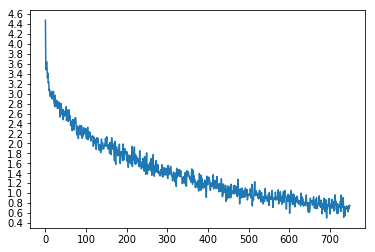

In [31]:
save_dir = 'data/translation'
sign = 'CustomizeDecoderRNN_general'
checkpoint_iteration = 75000
n_iteration = 75000
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
learning_rate = 0.01
start_iteration = 1
save_every=5000
print_every=5000
plot_every=100
load_filename = None
# load_filename = os.path.join(save_dir, '{}-{}-{}_{}.tar'.format(input_lang.name, output_lang.name, sign, checkpoint_iteration))


hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size)
# decoder = CustomizeDecoderRNN('general',hidden_size, output_lang.n_words, dropout_p=0.1)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

if load_filename:
    checkpoint = torch.load(load_filename)
    start_iteration = checkpoint['iteration']
    encoder_sd = checkpoint['en']
    encoder.load_state_dict(encoder_sd)
    decoder_sd = checkpoint['de']
    decoder.load_state_dict(decoder_sd)
    encoder_op_sd = checkpoint['en_opt']
    encoder_optimizer.load_state_dict(encoder_op_sd)
    decoder_op_sd = checkpoint['de_opt']
    decoder_optimizer.load_state_dict(decoder_op_sd)
    input_lang.__dict__ = checkpoint['input_lang']
    output_lang.__dict__ = checkpoint['output_lang']
    
    
encoder = encoder.to(device)
decoder = decoder.to(device)

%matplotlib inline
trainIters(encoder, decoder, input_lang, output_lang, encoder_optimizer, decoder_optimizer,
           save_dir, n_iteration, sign, save_every, print_every, plot_every,learning_rate, start_iteration)

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [32]:
evaluateRandomly(encoder, decoder)

> je n en suis pas convaincue .
= i m not convinced of that .
< i m not convinced of that . <EOS>

> nous allons essayer .
= we re going to try .
< we re going to try . <EOS>

> je suis sure que ca peut attendre .
= i m sure this can wait .
< i m sure this can this . . <EOS>

> je suis plutot occupe ce soir .
= i m kind of busy tonight .
< i m kind of busy tonight . <EOS>

> elles sont riches .
= they re rich .
< they re rich . <EOS>

> vous etes responsables de ce que vous faites .
= you are responsible for what you do .
< you re responsible for what you do . <EOS>

> vous n etes pas si vieilles .
= you re not that old .
< you re not that old . <EOS>

> je suis crevee .
= i m exhausted .
< i m exhausted . <EOS>

> je ne suis pas toujours libre le dimanche .
= i m not always free on sundays .
< i am not always free on sundays . <EOS>

> tu es sur la mauvaise route .
= you re on the wrong road .
< you re on the wrong . <EOS>



## 注意力可视化

注意机制的一个有用特性是其输出有高度可解释性。 因为它用于对输入序列时间步的编码器输出进行加权，所以我们可以想象在每个时间步上网络最关注的位置在哪里。

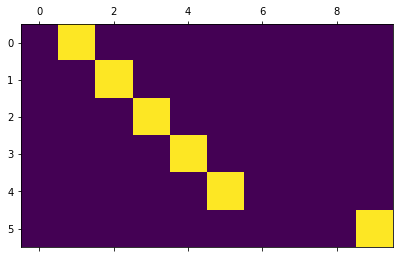

In [33]:
output_words, attentions = evaluate(
    encoder, decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


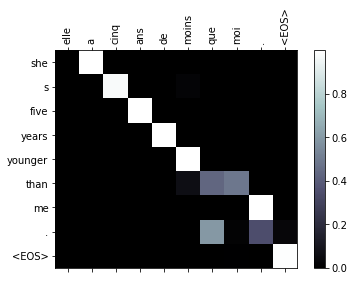

input = elle est trop petit .
output = she s too trusting . <EOS>


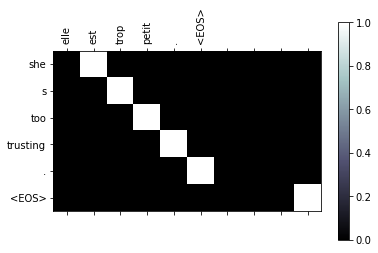

input = je ne crains pas de mourir .
output = i m not scared of die . <EOS>


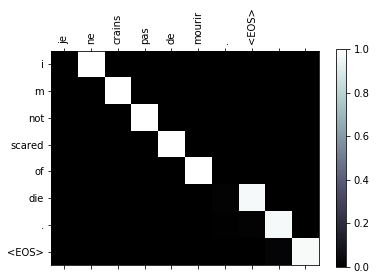

input = c est un jeune directeur plein de talent .
output = he s a talented talented talented . <EOS>


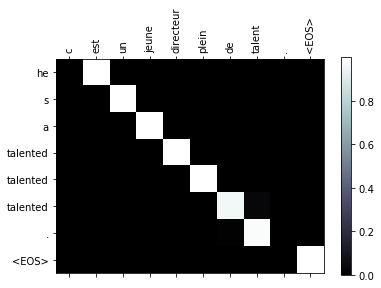

In [34]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = c est
output = he m being angry . <EOS>


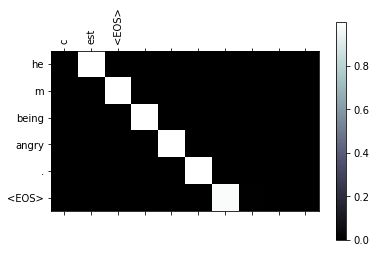

In [35]:
evaluateAndShowAttention('c est')